# **Baseline measurements**

Measurements with all the available occupation data:
- No federated learning
- 55 days available for learning
- 5 days for testing

In [1]:
EPOCHS = 100
TRAIN = range(0, 55)
TEST = range(55, 60)

In [17]:
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import neural_network
import utils

from importlib import reload
reload(neural_network);

## **Data preparation**

In [8]:
MEAS_ROOT = "../dockeroutput/"

In [9]:
#reading capacity data:
MOST_PATH = "../build_inputs//MoSTScenario/scenario/most.sumocfg"
PARKING_AREA_DEFINITIONS = "../build_inputs/MoSTScenario/scenario/in/add/most.parking.add.xml"

parking_df = pd.read_xml(PARKING_AREA_DEFINITIONS)
parking_df = parking_df[parking_df["roadsideCapacity"]>0]
parking_df = parking_df.set_index(["id"])

In [10]:
#constants for normalizing/standardizing:
nominals = pd.read_csv(MEAS_ROOT+"day_0/occupancies.csv")
perc_ = []
for i,r in nominals.iterrows():
    perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
nominals["percentage"] = perc_

In [11]:
MEAN = np.mean(nominals["percentage"])
STD = np.std(nominals["percentage"])
MIN_T = 14400
MAX_T = 50460

PARKING_ID_LIST = [i for i in range(1059, 1186+1)]

In [35]:
def collect_data(day_range):
    collected_data = None
    for day in day_range:
        meas_path = MEAS_ROOT + "day_%d/"%day
        df_ = pd.read_csv(meas_path+"occupancies.csv")
        perc_ = []
        for i,r in df_.iterrows():
            perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
        df_["percentage"] = perc_

        #one-hot-encoding:
        ohe = utils.one_hot_encoder(df_["ids"], PARKING_ID_LIST)
        #standardizing percentage values:
        percentages = np.array(df_["percentage"]).reshape(len(df_), 1)
        percentages = utils.standardize(percentages, MEAN, STD)
        #normalizing time values:
        times = np.array(df_["timestamp"]).reshape(len(df_), 1)
        times = utils.normalize(times, MIN_T, MAX_T)

        new_data = np.hstack([ohe, times, percentages])
        if collected_data is None:
            collected_data = new_data
        else:
            collected_data = np.vstack([collected_data, new_data])
    return collected_data

In [36]:
train_data = pd.DataFrame(collect_data(TRAIN))
train_data.to_csv("../02_data/nn_baseline_train.csv", header=False, index=False)

In [38]:
test_data = collect_data(TEST)

In [39]:
test_data = pd.DataFrame(test_data)
test_data.to_csv("../02_data/nn_baseline_test.csv", header=False, index=False)

## **Learning**

In [3]:
train_data = pd.read_csv("../02_data/nn_baseline_train.csv", header=None)

In [13]:
nn = neural_network.NeuralNetwork()

In [5]:
train_data = np.array(train_data.sample(frac=0.33))
#train_data = data[:int(len(data)*.7)]
#test_data = data[int(len(data)*.7)+1:]

In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = nn.model.fit(train_data[:,:-1],
                       train_data[:,-1], batch_size=1000, epochs=EPOCHS, validation_split=.3,
                       callbacks=[callback])
#eval_model = nn.model.evaluate(test_data[:,:-1], test_data[:,-1], batch_size=1000)

2023-01-26 09:09:32.185442: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 999100356 exceeds 10% of free system memory.
2023-01-26 09:09:32.502898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 999100356 exceeds 10% of free system memory.


Epoch 1/100
  76/1937 [>.............................] - ETA: 3s - loss: 0.4719 

2023-01-26 09:09:33.451967: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1937/1937 [==============================] - 5s 2ms/step - loss: 0.0589 - val_loss: 0.0091
Epoch 2/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0089 - val_loss: 0.0062
Epoch 3/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 4/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 5/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 6/100
1937/1937 [==============================] - 4s 2ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 7/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0033 - val_loss: 0.0060
Epoch 8/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/100
1937/1937 [==============================] - 4s 2ms/step - loss: 0.0027 

In [7]:
history.history

{'loss': [0.05894387140870094,
  0.008882240392267704,
  0.005869729444384575,
  0.004722069948911667,
  0.004051002208143473,
  0.0035931828897446394,
  0.0033207572996616364,
  0.003065899247303605,
  0.0028713445644825697,
  0.0027170125395059586,
  0.0025872294791042805,
  0.002486810553818941,
  0.0023848318960517645,
  0.002306973561644554,
  0.0022330647334456444,
  0.002151515567675233,
  0.002095251576974988,
  0.0020462418906390667,
  0.0019852854311466217,
  0.0019409805536270142,
  0.0019077915931120515,
  0.00186981912702322,
  0.0018236851319670677,
  0.0017901082755997777,
  0.001779693877324462],
 'val_loss': [0.009145076386630535,
  0.006177823059260845,
  0.005746179260313511,
  0.004628211259841919,
  0.0018400419503450394,
  0.002551213139668107,
  0.006010165438055992,
  0.002858767518773675,
  0.0024185720831155777,
  0.002478877315297723,
  0.0037036961875855923,
  0.0017264917260035872,
  0.0019312099320814013,
  0.0026994424406439066,
  0.001501162420026958,
  

### Saving the model

In [42]:
nn.model.save("../04_nn_models/baseline")

INFO:tensorflow:Assets written to: ../04_nn_models/baseline/assets


## **Testing**

In [14]:
nn.model = keras.models.load_model("../04_nn_models/baseline")

In [3]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Learning curves')

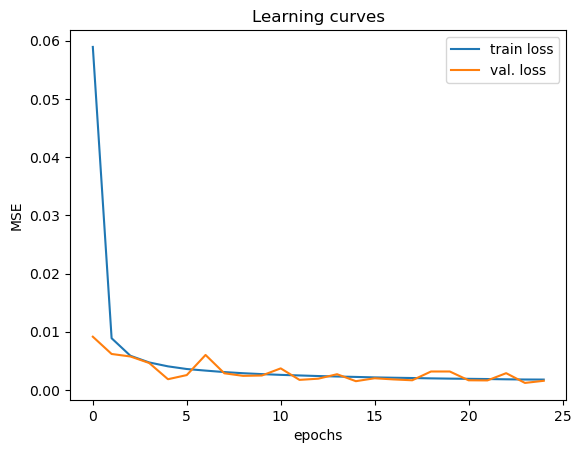

In [12]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val. loss")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning curves")

### **Testing with a specific parking lot**

In [20]:
PARKING_ID = 1150

In [21]:
id_list = PARKING_ID_LIST

test_t = np.arange(14400, 50400, 60)
test_t = utils.normalize(test_t, MIN_T, MAX_T)

id_encoding = utils.one_hot_encoder([PARKING_ID]*len(test_t), id_list)
#print(id_encoding.shape)

test_d = np.hstack([id_encoding, test_t.reshape(len(test_t), 1)])
#print(test_d.shape)

output = nn.model.predict(test_d)
output = utils.de_standardize(output, MEAN, STD)

19/19 [==============================] - 0s 769us/step


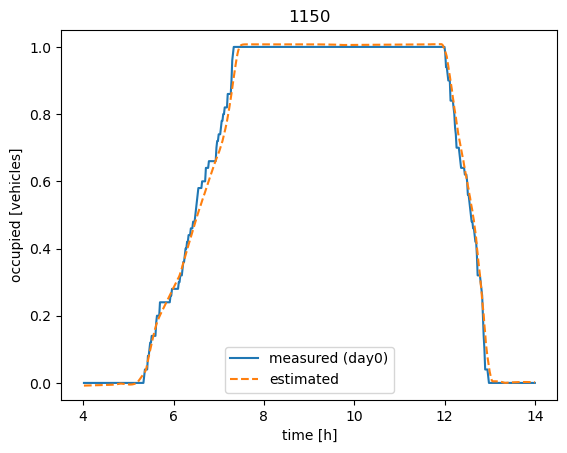

In [22]:
p_lot = nominals[nominals["ids"] == PARKING_ID]
p_lot_occup = p_lot.groupby("timestamp")["percentage"].mean()
plt.plot(p_lot_occup.index/(60*60), p_lot_occup, label="measured (day0)")
plt.plot(p_lot_occup.index/(60*60), output, "--", label="estimated")
plt.xlabel("time [h]")
plt.ylabel("occupied [vehicles]")
plt.legend()
plt.title(PARKING_ID)
plt.ylim(-.05, 1.05)
plt.show()

### **Testing with the last 5 days**

In [38]:
test_data = pd.read_csv("../02_data/nn_baseline_test.csv", header=None)
test_data = np.array(test_data)

In [41]:
result = nn.model.evaluate(test_data[:,:-1],
                  test_data[:,-1], batch_size=1000)

print("Test loss:\t%.4f"%result)

762/762 [==============================] - 1s 1ms/step - loss: 0.0018
Test loss:	0.0018
